In [ ]:
#Importing the dataset
from os import path
if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    !wget https://biolab.csr.unibo.it/samples/fr/files.zip
    !unzip files.zip

In [ ]:
#Including the required files
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact


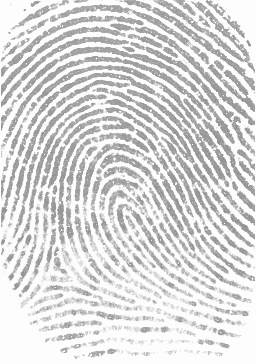

In [ ]:
#Loading/Reading the image
fingerprint = cv.imread('samples/sample_1_1.png', cv.IMREAD_GRAYSCALE)
show(fingerprint, f'Fingerprint with size (w,h): {fingerprint.shape[::-1]}')

In [ ]:
#fingerprint = cv.imread('101_2.png', cv.IMREAD_GRAYSCALE)
#if fingerprint is not None:
#    print('variable is not None')
#    print(fingerprint.shape)
#    show(fingerprint.shape)
#else:
#    print('variable is None')


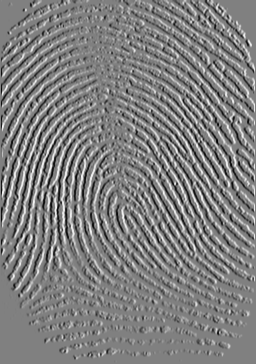
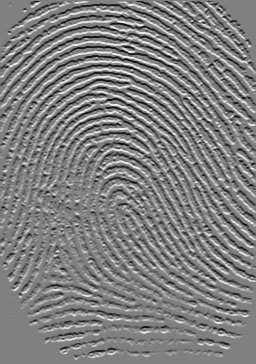

In [ ]:
#Fingerprint Segmentation
#Calculating the gradient (Sobel filters)
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)
show((gx, 'Gx'), (gy, 'Gy'))


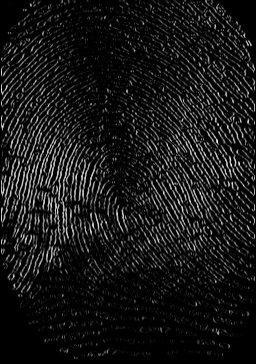
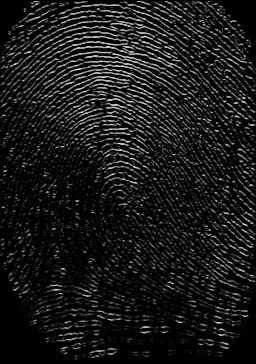
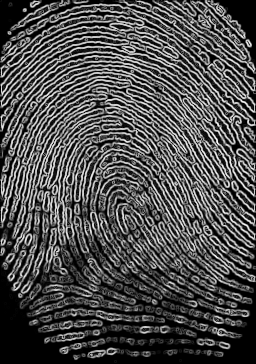

In [ ]:
#Calculating magnitude of the gradient for each pixel
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)
show((gx2, 'Gx**2'), (gy2, 'Gy**2'), (gm, 'Gradient magnitude'))


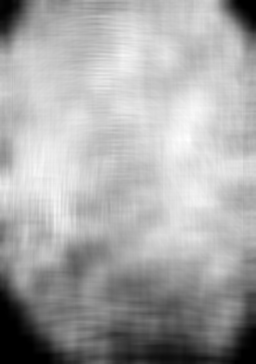

In [ ]:
#Integral over a square window
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
show(sum_gm, 'Integral of the gradient magnitude')


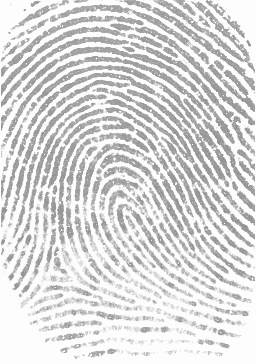
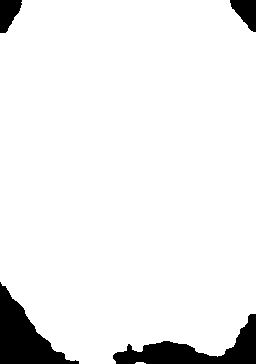
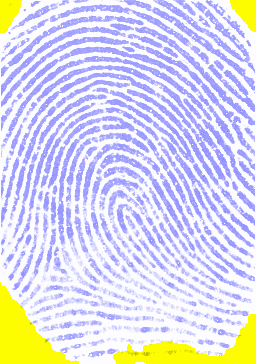

In [ ]:
# Using a simple threshold for segmenting the fingerprint pattern
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


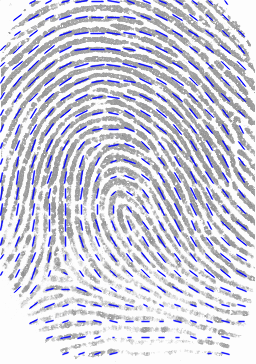

In [ ]:
#Estimation of local ridge orientation
W = (23, 23)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2
sum_gxx_gyy = gxx + gyy
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')


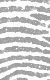

In [ ]:
#Estimation of local ridge frequency
region = fingerprint[10:90,80:130]
show(region)

In [ ]:
#before computing the x-signature, the region is smoothed to reduce noise
smoothed = cv.blur(region, (5,5), -1)
xs = np.sum(smoothed, 1) #the x-signature of the region
print(xs)

[10697 10796 11245 11970 12058 11508 10815 10064  9314  9125  9707 10389
 10912 11370 11564 11116 10419  9916  9532  9250  9370  9833 10348 10899
 11430 11429 11180 10773 10152  9409  9243  9351  9847 10620 11430 11482
 11147 10536  9791  9010  8966  9337  9845 10431 10986 11071 10877 10416
  9732  9264  9514  9946 10642 11353 11533 11050 10398  9649  9345  9636
 10183 10614 10849 10646 10197  9827  9762  9908 10237 10529 10628 10437
 10203 10011 10108 10364 10658 10828 10986 11106]


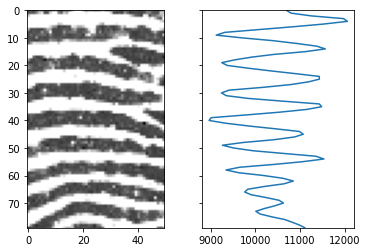

In [ ]:
x = np.arange(region.shape[0])
f, axarr = plt.subplots(1,2, sharey = True)
axarr[0].imshow(region,cmap='gray')
axarr[1].plot(xs, x)
axarr[1].set_ylim(region.shape[0]-1,0)
plt.show()

In [ ]:
local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]
distances = local_maxima[1:] - local_maxima[:-1]
print(distances)

[10 10 11 10  9  8  8]


In [ ]:
ridge_period = np.average(distances)
print(ridge_period)

9.428571428571429


In [ ]:
#
local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

In [ ]:
pip install GaborNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 40.5 MB/s 
     |████████████████████████████████| 748.8 MB 23 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.6.0 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.6.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.6

In [ ]:
#Fingerprint enhancement
import torch
import torch.nn as nn
from torch.nn import functional as F
from GaborNet import GaborConv2d

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.g0 = GaborConv2d(in_channels=1, out_channels=96, kernel_size=(11, 11))
        self.c1 = nn.Conv2d(96, 384, (3,3))
        self.fc1 = nn.Linear(384*3*3, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.leaky_relu(self.g0(x))
        x = nn.MaxPool2d()(x)
        x = F.leaky_relu(self.c1(x))
        x = nn.MaxPool2d()(x)
        x = x.view(-1, 384*3*3)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = GaborNN().to(device)



In [ ]:
import math
from typing import Any

import torch
from torch.nn import Parameter
from torch.nn.modules import Conv2d, Module


class GaborConv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = Parameter(
            (math.pi / 2)
            * math.sqrt(2)
            ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),
            requires_grad=True,
        )
        self.theta = Parameter(
            (math.pi / 8)
            * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),
            requires_grad=True,
        )
        self.sigma = Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = Parameter(
            math.pi * torch.rand(out_channels, in_channels), requires_grad=True
        )

        self.x0 = Parameter(
            torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False
        )
        self.y0 = Parameter(
            torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False
        )

        self.y, self.x = torch.meshgrid(
            [
                torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
                torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),
            ]
        )
        self.y = Parameter(self.y)
        self.x = Parameter(self.x)

        self.weight = Parameter(
            torch.empty(self.conv_layer.weight.shape, requires_grad=True),
            requires_grad=True,
        )

        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(
                    -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2)
                )
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g

    def _forward_unimplemented(self, *inputs: Any):
        """
        code checkers makes implement this method,
        looks like error in PyTorch
        """
        raise NotImplementedError

In [ ]:
import numpy as np
import torch

from GaborNet import GaborConv2d


def test_kenrel_shape():
    k = np.random.randint(11, 15)
    layer = GaborConv2d(1, 1, (k, k))
    shape = np.array(layer.weight.shape)
    result = k
    assert result == shape[-1]


def test_output_size():
    s = np.random.randint(3, 9)
    layer = GaborConv2d(1, s, (11, 11))
    shape = np.array(layer.weight.shape)
    result = s
    assert result == shape[0]


def test_input_size():
    s = np.random.randint(3, 9)
    layer = GaborConv2d(s, 1, (11, 11))
    shape = np.array(layer.weight.shape)
    result = s
    assert result == shape[1]


def test_layer_work():
    img = np.random.randn(1, 1, 100, 100)
    img = torch.Tensor(img)
    k = np.random.randint(11, 15)
    layer = GaborConv2d(1, 1, (k, k))
    output = layer(img)
    shape = np.array(output.shape)
    result = 100 - k + 1
    assert result == shape[-1] == shape[-2]






In [ ]:
or_count = 8
gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]



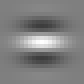
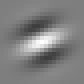
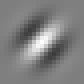
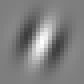
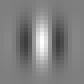
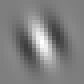
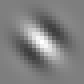
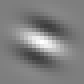

In [ ]:
show(*gabor_bank)


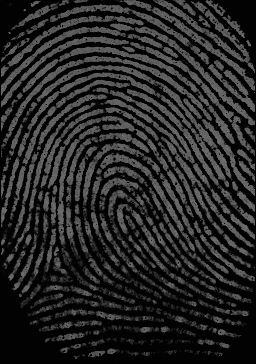
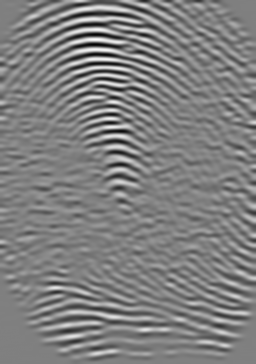
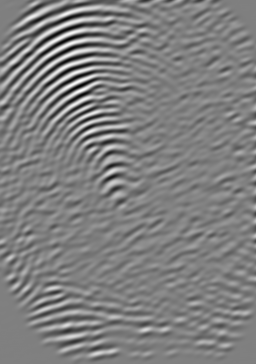
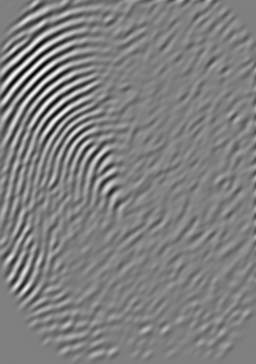
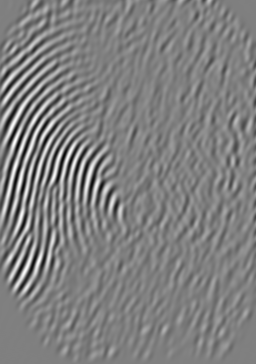
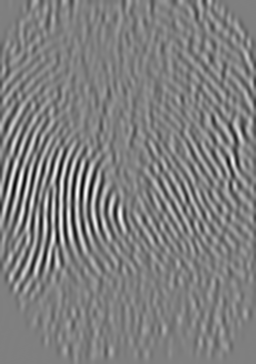
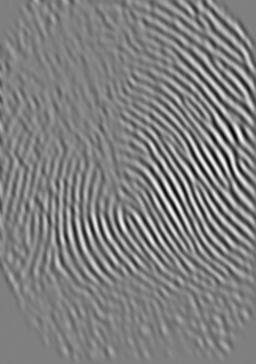
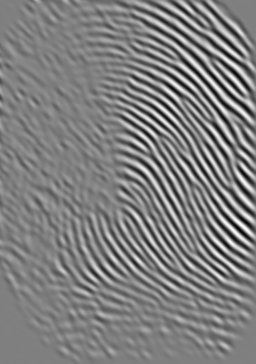
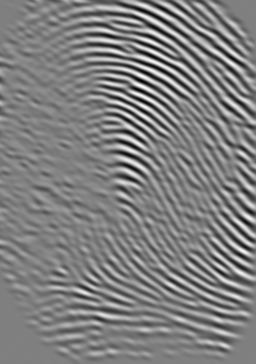

In [ ]:
# Filter the whole image with each filter
nf = 255-fingerprint
all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])
show(nf, *all_filtered)


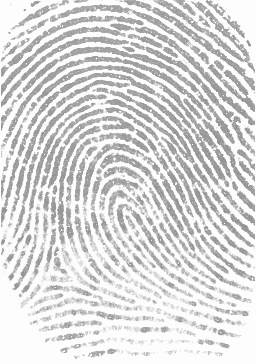
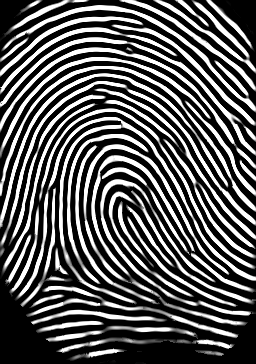

In [ ]:
y_coords, x_coords = np.indices(fingerprint.shape)
orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
filtered = all_filtered[orientation_idx, y_coords, x_coords]
enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
show(fingerprint, enhanced)


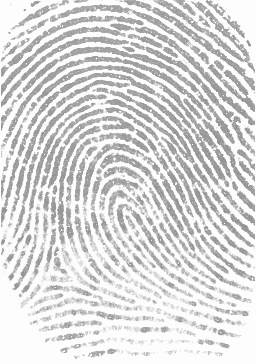
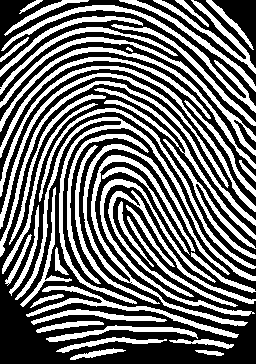
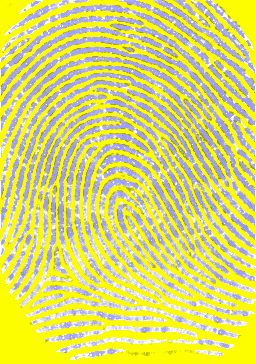

In [ ]:
#Detection of minutiae positions
#Binarization
_, ridge_lines = cv.threshold(enhanced, 32, 255, cv.THRESH_BINARY)
show(fingerprint, ridge_lines, cv.merge((ridge_lines, fingerprint, fingerprint)))


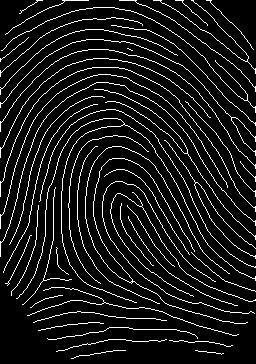
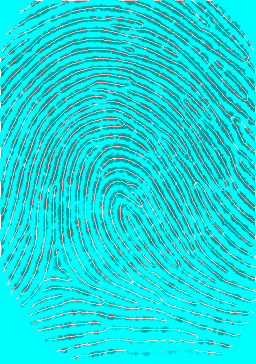

In [ ]:
skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

In [ ]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [ ]:
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

In [ ]:
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

In [ ]:
skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
cn = cv.LUT(cn_values, cn_lut)
cn[skeleton==0] = 0

In [ ]:
minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]


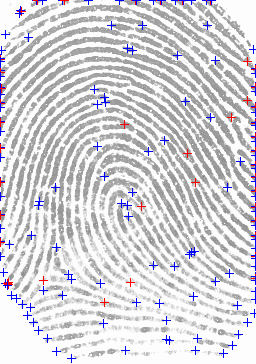
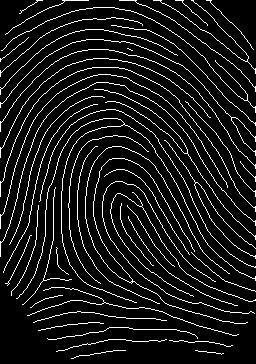
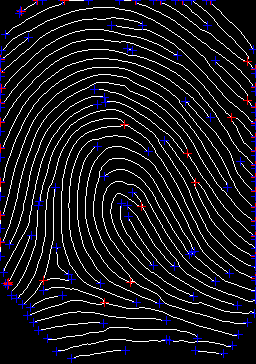

In [ ]:
show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))


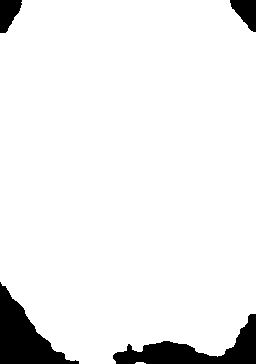
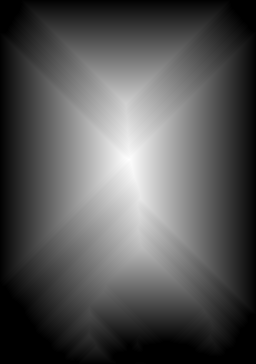

In [ ]:
mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
show(mask, mask_distance)

In [ ]:
filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))


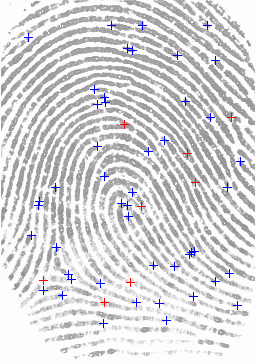
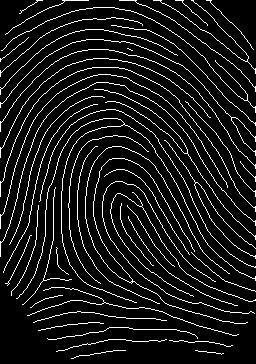
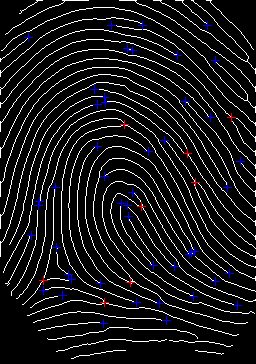

In [ ]:
show(draw_minutiae(fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))

In [ ]:
def compute_next_ridge_following_directions(previous_direction, values):
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8:
            next_positions = next_positions[:-1]
    return next_positions

In [ ]:
r2 = 2**0.5

xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

In [ ]:
def follow_ridge_and_compute_angle(x, y, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20:
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    return math.atan2(-py+y, px-x) if length >= 10 else None

In [ ]:
valid_minutiae = []
for x, y, term in filtered_minutiae:
    d = None
    if term:
        d = follow_ridge_and_compute_angle(x, y)
    else:
        dirs = nd_lut[cn_values[y,x]][8]
        if len(dirs)==3:
            angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
            if all(a is not None for a in angles):
                a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                d = angle_mean(a1, a2)
    if d is not None:
        valid_minutiae.append( (x, y, term, d) )

In [ ]:
mcc_radius = 70
mcc_size = 16

g = 2 * mcc_radius / mcc_size
x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
y = x[..., np.newaxis]
iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
ref_cell_coords = np.column_stack((x[ix], x[iy]))

In [ ]:
mcc_sigma_s = 7.0
mcc_tau_psi = 400.0
mcc_mu_psi = 1e-2

def Gs(t_sqr):
    """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
    return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

def Psi(v):
    """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
    return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))

In [ ]:
xyd = np.array([(x,y,d) for x,y,_,d in valid_minutiae])

d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

xy = xyd[:,:2]
cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

cs = Gs(dists)
diag_indices = np.arange(cs.shape[0])
cs[diag_indices,:,diag_indices] = 0

local_structures = Psi(np.sum(cs, -1))

In [ ]:
@interact(i=(0,len(valid_minutiae)-1))
def test(i=0):
    show(draw_minutiae_and_cylinder(fingerprint, ref_cell_coords, valid_minutiae, local_structures, i))

interactive(children=(IntSlider(value=0, description='i', max=51), Output()), _dom_classes=('widget-interact',…

In [ ]:
##model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(300,300,3))) #input layer model.add(Conv2D(32, kernel_size=3, activation='relu')) #this is a convolution layer model.add(Conv2D(64, kernel_size=3, activation='relu')) #this is another convolution layer model.add(Conv2D(64, kernel_size=3, activation='relu')) #this is another convolution layer model.add(Flatten()) #converts into 1-D array i.e. flattens model.add(Dense(1,activation='sigmoid')) #1 neurons. 2 diferent labels (Fake or Live)
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) #compiling the  model

#loading and classifying data into train and test sets train_datagen=ImageDataGenerator(rescale=-
#1./255,shear_range=0.1,zoom_range=0.2,horizontal_flip=False) test_datagen=ImageDataGenerator(rescale=1./255)
#train_set=train_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning
#IITI/Fingerprint/train",target_size=(300,300),batch_size=16,class_mode='binary') test_set=test_datagen.flow_from_directory("/content/drive/My Drive/Deep Learning IITI/Fingerprint/test",target_size=(300,300),batch_size=16,class_mode='binary')

#Fitting the model
#model.fit_generator(train_set,steps_per_epoch=25,epochs=3,validation_data=test_set,validation_steps=2) model.save_weights('hi.h5')  # to save weights after training


In [ ]:
#train_datagen=ImageDataGenerator(rescale=-1./255,shear_range=0.1,zoom_range=0.2,horizontal_flip=False) test_datagen=ImageDataGenerator(rescale=1./255) train_set=train_datagen.flow_from_directory("/content/drive/My Drive/MODEL1/Train",target_size=(300,300),batch_size=16,class_mode='binary') test_set=test_datagen.flow_from_directory("/content/drive/My Drive/MODEL1/Test",target_size=(300,300),batch_size=16,class_mode='binary')
#Designing compiling the CNN model model=Sequential() model.add(Conv2D(input_shape= (300,300,3),filters=64,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu')) model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu')) model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu')) model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu')) model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu')) model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(4096,activation='relu')) model.add(Dense(4096,activation='relu'))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.summary()
#from keras.callbacks import ModelCheckpoint,EarlyStopping
#checkpoint=ModelCheckpoint("vgg16_1.h5",monitor='val_acc',verbose=1,save_best_only=True) early=EarlyStopping(monitor='val_acc',patience=20,verbose=1)
#fitting the model
#model.fit_generator(generator=train_set,validation_data=test_set,steps_per_epoch=100,epochs=100,validati on_steps=10,callbacks=[checkpoint,early])


In [ ]:
print(f"""Fingerprint image: {fingerprint.shape[1]}x{fingerprint.shape[0]} pixels
Minutiae: {len(valid_minutiae)}
Local structures: {local_structures.shape}""")

Fingerprint image: 256x364 pixels
Minutiae: 52
Local structures: (52, 208)


In [ ]:
f1, m1, ls1 = fingerprint, valid_minutiae, local_structures

In [ ]:
#ofn = 'samples/sample_1_2'#fingerprint of a same finger
ofn = 'samples/sample_2' # Fingerprint of a different finger
f2, (m2, ls2) = cv.imread(f'{ofn}.png', cv.IMREAD_GRAYSCALE), np.load(f'{ofn}.npz', allow_pickle=True).values()

In [ ]:
dists = np.sqrt(np.sum((ls1[:,np.newaxis,:] - ls2)**2, -1))
dists /= (np.sqrt(np.sum(ls1**2, 1))[:,np.newaxis] + np.sqrt(np.sum(ls2**2, 1)))

In [ ]:
num_p = 5
pairs = np.unravel_index(np.argpartition(dists, num_p, None)[:num_p], dists.shape)
score = 1 - np.mean(dists[pairs[0], pairs[1]])
print(f'Comparison score: {score:.2f}')

Comparison score: 0.61


In [ ]:
@interact(i = (0,len(pairs[0])-1), show_local_structures = False)
def show_pairs(i=0, show_local_structures = False):
    show(draw_match_pairs(f1, m1, ls1, f2, m2, ls2, ref_cell_coords, pairs, i, show_local_structures))

interactive(children=(IntSlider(value=0, description='i', max=4), Checkbox(value=False, description='show_loca…